# Assignment 2 - Machine Learning
## FEUP MIEIC - Inteligência Artificial *(EIC0029/IART)*



## Neural Network partial notebook

This Jupyter Notebook implpementes and documents a Neural Network Machine Learning model. <br><br>
*The content of this notebook will be also included in the complete notebook named **IART-MachineLearning.ipynb** that can be found in the root directory of this repository*

***

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Connecting to database
database = "database.sqlite"
con = sqlite3.connect(database)
pd.set_option('display.max_columns', None)

#Get important tables from db
matches_df = pd.read_sql("""SELECT * from MATCH""", con)
teams_df = pd.read_sql("""SELECT * from TEAM""", con)
player_attributes_df = pd.read_sql("""SELECT * from PLAYER_ATTRIBUTES""", con)
team_attributes_df = pd.read_sql("""SELECT * from TEAM_ATTRIBUTES""", con)

#Get players' attributes (overall)

#Get players info
home_players = ["home_player_" + str(x) for x in range(1, 12)]
away_players = ["away_player_" + str(x) for x in range(1, 12)]

matches_kept_columns = ["id", "league_id", "date", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal"]
matches_kept_columns = matches_kept_columns + home_players
matches_kept_columns = matches_kept_columns + away_players

matches_df = matches_df[matches_kept_columns]

#Get overall ratings for all players from player_attributes table
for player in home_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])
for player in away_players:
    matches_df = pd.merge(matches_df, player_attributes_df[["id", "overall_rating"]], left_on=[player], right_on=["id"], suffixes=["", "_" + player])
 

matches_df = matches_df.rename(columns={"overall_rating": "overall_rating_home_player_1"})

matches_df['overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].sum(axis=1)
matches_df['overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].sum(axis=1)
matches_df['overall_rating_difference'] = matches_df['overall_rating_home'] - matches_df['overall_rating_away']

matches_df['mean_overall_rating_home'] = matches_df[['overall_rating_' + p for p in home_players]].mean(axis=1)
matches_df['mean_overall_rating_away'] = matches_df[['overall_rating_' + p for p in away_players]].mean(axis=1)


#Remove all players column because we just need the "global" ones
for c in matches_df.columns:
    if '_player_' in c:
        matches_df = matches_df.drop(c, axis=1)

#function to calculate last 5 games performance
def last5(team_id, date, match_t):
     
    mat = match_t[(match_t['date'] < date)]
    mat = mat[mat['home_team_api_id'] == team_id]
    
    mat5 = mat.head(5)
    if len(mat5.index) < 5:
        return -1
    mat5['Home result'] = 0
    mat5['Home result'] = np.where(mat5['home_team_goal'] > mat5['away_team_goal'], 3, mat5['Home result'])
    mat5['Home result'] = np.where(mat5['home_team_goal'] == mat5['away_team_goal'], 1, mat5['Home result'])
    total = mat5['Home result'].sum()
    return total

match_t = matches_df[['home_team_api_id', 'away_team_api_id','date', 'home_team_goal', 'away_team_goal']].copy()
match_t['date'] = pd.to_datetime(match_t['date'])
match_t.sort_values(by=['date'], inplace=True, ascending=False) 
matches_df['Home_last5'] = 0
matches_df['Away_last5'] = 0
perc = 0
for i in matches_df.index:
    Htotal = last5(match_t['home_team_api_id'].iloc[i], match_t['date'].iloc[i], match_t)
    Atotal = last5(match_t['away_team_api_id'].iloc[i], match_t['date'].iloc[i], match_t)
    matches_df['Home_last5'].values[i] = Htotal
    matches_df['Away_last5'].values[i] = Atotal
    if i % 655 == 0:
        perc += 10
        print(perc, "%", end=" ")

matches_df

matches_aux = pd.read_sql("""SELECT * FROM MATCH""" ,con)

#Select all bet columns (removed PSA, PSH, PSD because they are almost all NaN)
bet_columns = ["B365H", "B365A", "B365D", "BWH", "BWD", "BWA", "IWH", "IWD", "IWA", "LBH", "LBD", "LBA", "WHH", "WHD", "WHA", "SJH", "SJD", "SJA", "VCH", "VCD", "VCA", "GBH", "GBD", "GBA", "BSH", "BSD", "BSA"]

#Get specific columns for bets on home and draw
bet_columns_home = ["B365H", "BWH","IWH", "LBH", "WHH", "SJH", "VCH", "GBH","BSH"]
bet_columns_draw = ["B365D", "BWD","IWD", "LBD", "WHD", "SJD", "VCD", "GBD","BSD"]

#Calculate mean values for bets on home team and draw. Add these values to match table
matches_df['mean_bets_home'] = matches_aux[bet_columns_home].mean(axis=1)
matches_df['mean_bets_draw'] = matches_aux[bet_columns_draw].mean(axis=1)
#Replace NaN values (on bets) with mean values 
matches_df.fillna(matches_df.mean(), inplace=True)
matches_df.isnull().sum()

#Get goal difference
matches_df['goal_diff'] = matches_df['home_team_goal'] - matches_df['away_team_goal']

matches_df['Game Result'] = 'Defeat'
matches_df['Game Result'] = np.where(matches_df['goal_diff'] == 0, 'Draw', matches_df['Game Result'])
matches_df['Game Result'] = np.where(matches_df['goal_diff'] > 0, 'Win', matches_df['Game Result'])

10 %20 %30 %40 %50 %60 %70 %80 %90 %100 %

In [8]:
matches_df = matches_df.drop(['id', 'date', 'home_team_api_id','away_team_api_id','home_team_goal','away_team_goal', 'goal_diff'], axis=1)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier



y = matches_df['Game Result']
X = matches_df.drop('Game Result', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
from time import time

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

n_iter_search = 10
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = MLPClassifier(verbose=1, random_state=21, learning_rate=1e-05)


random_search = RandomizedSearchCV(clf, param_distributions=parameter_space, n_iter=n_iter_search)

start = time()
print("Start")
#random_search.fit(X_train_scaled, y_train)
print("End")
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

, loss = 1.05145322
Iteration 89, loss = 1.05139759
Iteration 90, loss = 1.05143056
Iteration 91, loss = 1.05130988
Iteration 92, loss = 1.05118868
Iteration 93, loss = 1.05126778
Iteration 94, loss = 1.05113677
Iteration 95, loss = 1.05116673
Iteration 96, loss = 1.05106599
Iteration 97, loss = 1.05102632
Iteration 98, loss = 1.05094720
Iteration 99, loss = 1.05095917
Iteration 100, loss = 1.05090309
Iteration 101, loss = 1.05080562
Iteration 102, loss = 1.05075316
Iteration 103, loss = 1.05069256
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.13546904
Iteration 2, loss = 1.10332591
Iteration 3, loss = 1.08293867
Iteration 4, loss = 1.07342338
Iteration 5, loss = 1.06790042
Iteration 6, loss = 1.06491832
Iteration 7, loss = 1.06265267
Iteration 8, loss = 1.06120285
Iteration 9, loss = 1.06010569
Iteration 10, loss = 1.05943095
Iteration 11, loss = 1.05882100
Iteration 12, loss = 1.05819356
Iteration 13, loss = 1.05785507

In [20]:
random_search.score(X_test_scaled, y_test)

0.4707080998471727

[[  0   0 538]
 [  0   0 501]
 [  0   0 924]]


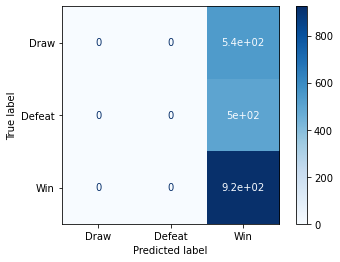

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

class_names= {"Defeat","Draw", "Win"}

disp = plot_confusion_matrix(random_search, X_test_scaled, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
print(disp.confusion_matrix)

# WE NEED TO BALANCE THE DATA SET!

5. Use Tree-Based Algorithms
The final tactic we'll consider is using tree-based algorithms. Decision trees often perform well on imbalanced datasets because their hierarchical structure allows them to learn signals from both classes.

In [38]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

y = matches_df['Game Result']
X = matches_df.drop('Game Result', axis=1)

# apply regular SMOTE
method = SMOTE()
X, y = method.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


yList = list(y) 

print(yList.count("Draw"))

print(yList.count("Win"))

print(yList.count("Defeat"))

3079
3079
3079
